## 导入包

In [2]:
import numpy as np
import pandas as pd
#这是Jupyter Notebook的魔法变量，可以方便的展示图像，用其他ide的可以删除这行
%matplotlib inline 
import matplotlib.pyplot as plt

## 获取数据

### 下载数据

In [3]:
import os
import requests

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
#项目下的文件目录  datasets\housing
HOUSING_PATH = os.path.join("datasets", "housing")
#文件下载地址 https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.csv"

def download_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    #文件地址 /datasets/housing/housing.csv
    csv_path = os.path.join(housing_path, "housing.csv")
    r = requests.get(HOUSING_URL)
    with open(csv_path,'wb') as f:
        f.write(r.content)
    r.close()

In [5]:
download_data()

SSLError: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /ageron/handson-ml/master/datasets/housing/housing.csv (Caused by SSLError(SSLError("bad handshake: SysCallError(10054, 'WSAECONNRESET')")))

### 查看数据

In [3]:
#用pandas读取文件
housing = pd.read_csv("datasets\housing\housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

## 创建测试集

### 全随机采样

In [4]:
from sklearn.model_selection import train_test_split
#test_size是分割的百分比，random_state是随机数种子
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### 分层采样

In [5]:
#np.ceil向上取整
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
#除小于5的值以外都改为5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

#n_splits为切割次数，我们按照"income_cat"属性进行切分，所以只用切分一次
#test_size是测试集比例，random_state是随机数种子
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [7]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## 分析数据

In [8]:
housing = strat_train_set.copy()

### 地理数据可视化

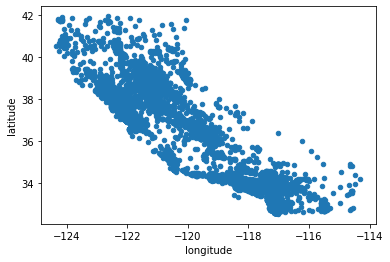

In [13]:
housing.plot(kind="scatter", x="longitude", y="latitude")

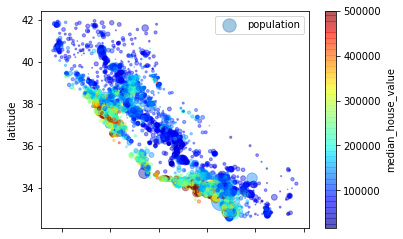

In [15]:
#s表示半径，指定为人口数/100
#c表示颜色，指定根据房价变化
#cmap是颜色集，可以自动根据数值大小选定颜色
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population",
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

### 查找关联

In [28]:
#corr函数计算每对属性之间的标准相关系数
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.665871
total_rooms           0.135118
housing_median_age    0.121438
households            0.072180
total_bedrooms        0.058084
longitude             0.019106
population           -0.031987
latitude             -0.178188
Name: median_house_value, dtype: float64

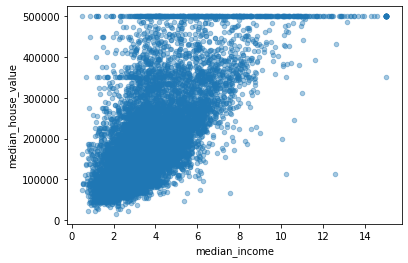

In [30]:
housing.plot(kind="scatter", x="median_income",y="median_house_value",alpha=0.4)

## 数据整理

In [71]:
housing = strat_train_set.drop("median_house_value", axis=1)#删除房价列后复制给新的变量
housing_labels = strat_train_set["median_house_value"].copy()#标签

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


### 数据清洗

In [12]:
housing.info()#查看数据的信息

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [13]:
#删除非数据类型的属性
housing_num = housing.drop("ocean_proximity", axis=1)

In [14]:
from sklearn.preprocessing import Imputer
#建立一个填补缺失的工具imputer，策略是使用中位数
imputer = Imputer(strategy="median")
#将imputer拟合到数据集
imputer.fit(housing_num)
#将缺失值替换为中位数
X = imputer.transform(housing_num)
#将X(这是numpy数组)转换为Pandas的Dataframe数据集类型
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr

D:\WorkSoftware\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0
...,...,...,...,...,...,...,...,...,...
16507,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0
16508,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0
16509,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0
16510,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0


In [15]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
dtypes: float64(9)
memory usage: 1.1 MB


### 数据转换

In [22]:
from sklearn.preprocessing import LabelBinarizer
#建立转换器encoder，参数为False时为Numpy数组，参数为True时为稀疏矩阵节约空间
encoder = LabelBinarizer(sparse_output=False)
#取出文本类型ocean_proximity
housing_cat = housing["ocean_proximity"]
#将文本转换为独热编码（numpy数组形式）
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### 自定义工具

In [26]:
#sklearn是不能直接处理DataFrames的，那么我们需要自定义一个处理的方法将之转化为numpy类型
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names): #可以为列表
        self.attribute_names = attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values #返回的为numpy array

In [34]:
# 添加一个特征组合的装换器
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]  # X[:,3]表示的是第4列所有数据
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # np.c_表示的是拼接数组。
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [35]:
#备用工具，下一节的代码中的备用独热编码工具类

# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

### 工具组合

In [41]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline                 #流水线组合工具
from sklearn.preprocessing import StandardScaler      #标准化工具类
#其他的工具类都在上面，提示没找到类的话，先把6.3节的两个自定义工具类加上，再把下面两行注释去掉
#from sklearn.preprocessing import Imputer             替换工具类
#from sklearn.preprocessing import LabelBinarizer      独热编码工具类


num_attribs = list(housing_num)#数字处理
cat_attribs = ["ocean_proximity"]#文字处理（ocean_proximity类是文字型）

#具体功能参见上表
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    #('label_binarizer', LabelBinarizer()),
    #如果label_binarizer因版本原因用不了，把上一行删除用下面这个工具
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")), #提示没有这个类就运行一下上一节的第三块代码CategoricalEncoder类
])

#将两个处理工具放在一起
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
housing_prepared.shape

D:\WorkSoftware\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

(16512, 17)